# Create Label Hierarchies

In this notebook, we first build a sample image from the ZüriCrop dataset to test the Prithvi demo. Then, from the `labels.csv` in the original ZueriCrop dataset, we reconstruct a clean version of the label hierarchy. We continue to define two additonal hierarchies, Seasonality and Seasonality Reduced.

## ZüriCrop Datensatz

In this section we examine the ZüriCrop dataset with the aim of creating a GeoTiff that can be uploaded to the Huggingface demo: 

[https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo](https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo)

In [1]:
from torchgeo.datasets import ZueriCrop
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
import rasterio
import numpy as np
import pandas as pd
import os


zueri_crop = ZueriCrop(root="zueri-crop", download=True)

Der Datensatz kann via TorchGeo in wenigen Minuten heruntergeladen werden (mit einer 1Gbit/s Verbindung). 

In [2]:
dataset = zueri_crop
print(dataset)

ZueriCrop Dataset
    type: NonGeoDataset
    size: 27977


Der Datensatz setzt sich aus ca. 28k Bildern zusammen.

In [3]:
print(len(dataset[0]))
print(dataset[0].keys())

4
dict_keys(['image', 'mask', 'boxes', 'label'])


Jeder Datenpunkt besteht aus 4 Teilen:
- image (142x9x24x24) - 142 Zeitpunkte, 9 Bänder, 24x24 Pixel
- mask (Nx24x24) - N Crops (auf diesem Bild), 24x24 Pixel
- boxes (Nx4) - N Crops (auf diesem Bild), 4 Koordinaten (x1, y1, x2, y2)
- labels (N) - N Crops (auf diesem Bild), Crop Typ

In [4]:
print(dataset[0]["image"].shape)

torch.Size([142, 9, 24, 24])


Ein Bild besteht aus 142 Zeitpunkten mit jeweils 9 Bändern udn einer Auflösung von 24x24 Pixeln.

Die Channels sind folgende:

("NIR", "B03", "B02", "B04", "B05", "B06", "B07", "B11", "B12")

RGB_BANDS = ["B04", "B03", "B02"]

- NIR: Near Infrared: B8 (842 nm)
- B03: Green
- B02: Blue
- B04: Red
- B05: Red Edge 1 (705 nm)
- B06: Red Edge 2 (740 nm)
- B07: Red Edge 3 (783 nm)
- B11: SWIR 1 (1610 nm)
- B12: SWIR 2 (2190 nm)

Verglichen mit HSL (Finetungingdaten des Prithvi-Modells) brauchen wir nur die Kanäle NIR, B03, B02, B04, B11 und B12 (6 Kanäle). Die Kanäle B05, B06 und B07 können entfernt werden.

Hier ist eine Übersicht der Bänder und ihrer Wellenlängen: [https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial)

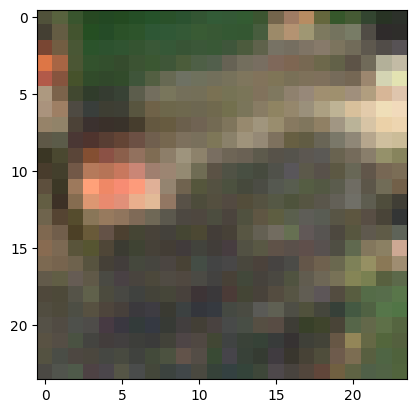

In [5]:
image = dataset[0]["image"][0, [3,1,2]].permute(1, 2, 0)
plt.imshow(image/image.max())
plt.show()

Das Laden des Bildes hat funktioniert!

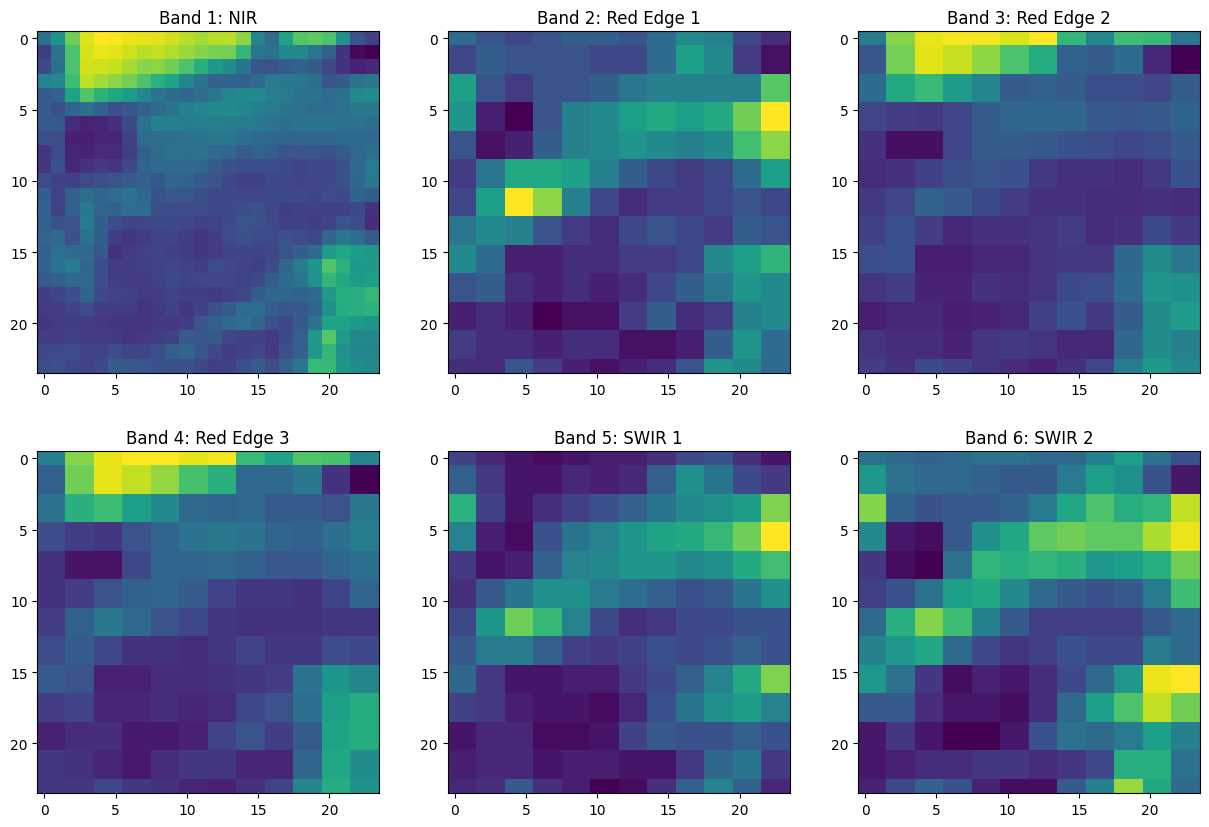

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
other_bands = [0, 4, 5, 6, 7, 8]

channel_names = [
    "NIR",
    "Green",
    "Blue",
    "Red",
    "Red Edge 1",
    "Red Edge 2",
    "Red Edge 3",
    "SWIR 1",
    "SWIR 2"
]
for i in range(6):
    ax = axs[i//3, i%3]
    ax.imshow(dataset[0]["image"][0, other_bands[i], :, :])
    ax.set_title(f"Band {i+1}: {channel_names[other_bands[i]]}")

Bei den anderen 6 Bändern die nicht RGB sind, hat nur das NIR-Band eine Auflösung von 10m, die anderen 5 Bänder haben eine Auflösung von 20m.

In [7]:
print('mask shape', dataset[0]["mask"].shape)
print('mask type', dataset[0]["mask"].dtype)

mask shape torch.Size([3, 24, 24])
mask type torch.uint8


Eine Maske besteht aus mehreren Labels (3 in diesem Fall) und 24 x 24 Pixel.

In [8]:
print(dataset[0]["boxes"].shape)

torch.Size([3, 4])


Liste der Bounding Boxen für jedes Label:
- Auch wieder drei Labels
- Jedes Label hat eine Bounding Box, die durch 4 Werte definiert ist: x, y, width, height

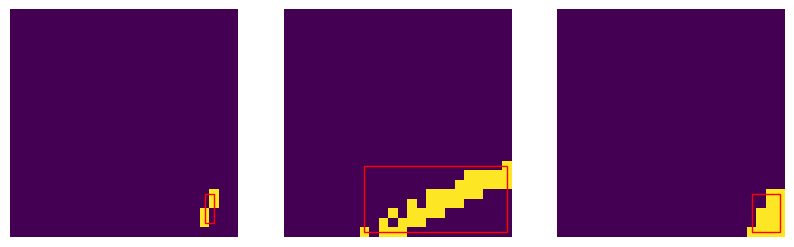

In [9]:
import matplotlib.patches as patches

masks = dataset[0]["mask"]
boxes = dataset[0]["boxes"]

fig, axs = plt.subplots(1, masks.shape[0], figsize=(10, 5))
for i, ax in enumerate(axs):
    ax.imshow(masks[i])
    rect = patches.Rectangle((boxes[i, 0], boxes[i, 1]), boxes[i, 2]-boxes[i, 0], boxes[i, 3]-boxes[i, 1], linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    ax.axis("off")

Was der Nutzen der Bounding Box ist, ist nicht so klar.

In [10]:
print(dataset[0]["label"].shape)
print(dataset[0]["label"])

torch.Size([3])
tensor([62, 60, 10])


Gibt die Label IDs der Masken an (die auch zu den Bounding Boxen gehören).
Label IDs können mehrfach vorkommen, da es mehrere Felder/Masken für ein Label geben kann.

In [11]:
print(dataset[705]["label"].shape)
print(dataset[705]["mask" ].shape)

torch.Size([15])
torch.Size([15, 24, 24])


In [12]:
ids = set()
for i in tqdm(range(len(dataset))):
    ids.update(dataset[i]["label"].tolist())

100%|██████████| 27977/27977 [00:42<00:00, 665.02it/s]


In [13]:
print(f"Anzahl der einzigartigen Labels: {len(ids)}")
print(f"kleinstes Label: {min(ids)}, grösstes Label: {max(ids)}")

Anzahl der einzigartigen Labels: 120
kleinstes Label: 0, grösstes Label: 124


Der Datensatz besteht aus 120 einzigartigen Labels die ihre IDs zwischen 0 und 124 haben.

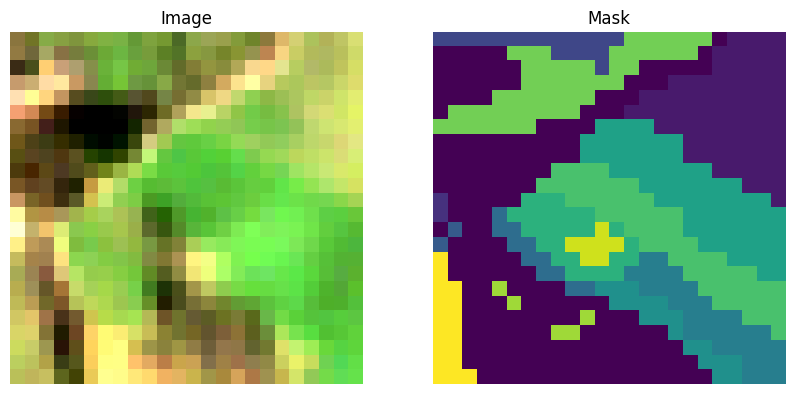

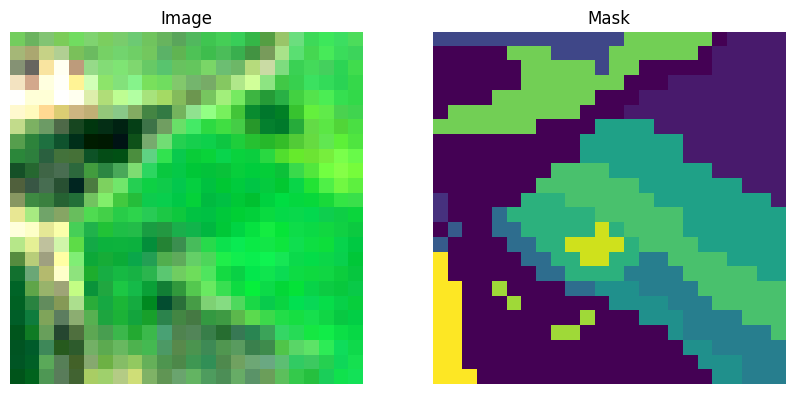

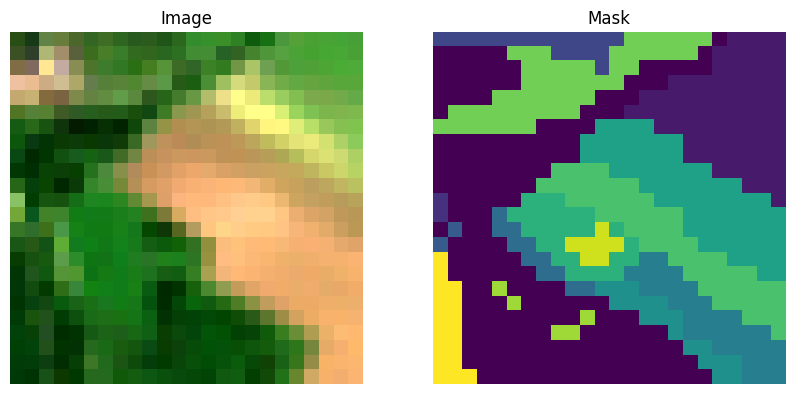

In [14]:
dataset.plot(dataset[705], time_step=15)
plt.show()
dataset.plot(dataset[705], time_step=38)
plt.show()
dataset.plot(dataset[705], time_step=56)
plt.show()

Hier sind 3 Zeitpunkte eines Bildes zu sehen. Das wird verwendet um ein Beispielbild zu erstellen, dass in die Huggingface Demo hochgeladen werden kann.

In [15]:
image_id = 705
time_steps = [15, 38, 56]

channels = [2, 1, 3, 0, 7, 8]

images = []
for i, time_step in enumerate(time_steps):
    image = dataset[image_id]["image"][time_step, channels]
    images.append(image)
img = np.stack(images).reshape(3*6, 24, 24)
print(img.shape) # (18, 24, 24)

# HACK: repeat the contents such that the image is 18x224x224
img = np.repeat(img, 10, axis=1)[:, :224, :]
img = np.repeat(img, 10, axis=2)[:, :, :224]

print(img.dtype) # int16
print(img.min(), img.max()) # 5 6444
print(img.shape) # (18, 224, 224)

os.makedirs("zueri-crop", exist_ok=True)
open(f"zueri-crop/{image_id}.tif", "w").close()
with rasterio.open(f"zueri-crop/{image_id}.tif", "w", driver="GTiff", width=224, height=224, count=3*6, dtype=np.uint16) as dst:
    dst.write(img)

(18, 24, 24)
int16
5 6444
(18, 224, 224)


/opt/homebrew/Caskroom/miniforge/base/envs/bat-data/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Nun kann das Bild auf Huggingface hochgeladen werden: [https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo](https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-multi-temporal-crop-classification-demo)

## Label Hierarchy Analysis (Crop Types)

In [16]:
# load the labels.csv file
zuericrop_labels = pd.read_csv("zueri-crop/labels.csv")
zuericrop_labels = zuericrop_labels.set_index("GT")
zuericrop_labels = zuericrop_labels.rename_axis("label_id")
zuericrop_labels = zuericrop_labels.rename(columns={"4th_tier_ENG": "4th_tier"})

zuericrop_labels

,LNF_code,raw_DE,raw_ENG,1st_tier,2nd_tier,3rd_tier,4th_tier,empty
label_id,,,,,,,,
1,501,Sommergerste,summer barley,Vegetation,Field crops,SmallGrainCereal,SummerBarley,NaN
2,502,Wintergerste,Winter barley,Vegetation,Field crops,SmallGrainCereal,WinterBarley,NaN
3,504,Hafer,oats,Vegetation,Field crops,SmallGrainCereal,Oat,NaN
4,505,Triticale,triticale,Vegetation,Field crops,SmallGrainCereal,Wheat,NaN
5,506,Mischel Futtergetreide,mixed fodder cereals,Vegetation,Field crops,SmallGrainCereal,Grain,NaN
...,...,...,...,...,...,...,...,...
120,908,Regionsspezifische Biodiversitätsförderflächen,Region-specific biodiversity promotion areas,Vegetation,Grassland,BiodiversityArea,Biodiversity encouragement area,NaN
121,909,Hausgärten,home gardens,Vegetation,Special crops,Gardens,Gardens,NaN
122,911,Landwirtschaftliche Produktion in Gebäuden (z....,agricultural production in buildings (e.g. cha...,Infrastructure,NaN,NaN,NaN,NaN


Wir laden das mit dem Datensatz mitgelieferte labels.csv File.

In [17]:
pixels_by_label_count = {}
max_iter = 0
for i in tqdm(range(len(dataset))):
    if i > max_iter and max_iter > 0:
        break
    mask = dataset[i]['mask']
    label = dataset[i]['label']
    for j in range(len(label)):
        label_item = label[j].item()
        if label_item not in pixels_by_label_count:
            # initialize the label info
            if label_item == 0: # NOTE: 0 occurs in the mask but not in the labels.csv
                label_row = {'1st_tier': 'unknown', '2nd_tier': 'unknown', '3rd_tier': 'unknown', '4th_tier': 'unknown'}
            else:
                label_row = zuericrop_labels.loc[label_item]
            pixels_by_label_count[label_item] = {
                'label_id': str(label_item),
                'label_name': f"{label_item}_{label_row['1st_tier']}_{label_row['2nd_tier']}_{label_row['3rd_tier']}_{label_row['4th_tier']}",
                'count': 0
            }
        # accumulate the number of pixels for the label
        pixels_by_label_count[label_item]['count'] += mask[j].sum().item()

# sort by count, descending
pixels_by_label_count_sorted = {k: v for k, v in sorted(pixels_by_label_count.items(), key=lambda item: item[1]['count'], reverse=True)}

100%|██████████| 27977/27977 [01:08<00:00, 406.33it/s]


Nun zählen wir auf Pixel-Ebene, wie oft jedes Label im Datensatz vorhanden ist.

In [18]:
print("Number of labels:", len(pixels_by_label_count_sorted))

Number of labels: 120


Wie bereits zuvor aufgefallen ist, ist die Nummerierung auf 124 nicht durchgehend - 4 Nummern fehlen. Es ist unklar, wieso.

In [19]:
fig = go.Figure()
fig.add_trace(go.Bar(x=[n['label_id'] for n in pixels_by_label_count_sorted.values()], y=[v['count'] for v in pixels_by_label_count_sorted.values()]))
fig.update_layout(
    title="Number of pixels per label",
    xaxis_title="Label",
    yaxis_title="Number of pixels",
    yaxis_type="log"
)

Wie wir sehen, ist die Verteilung der Labels sehr ungleichmässig. Manche kommen auf über 1 Million Pixel vor, andere (ID 104) nur auf 3 Pixel.

In [20]:
fig = go.Figure()
fig.add_trace(go.Bar(x=[n['label_name'] for n in pixels_by_label_count_sorted.values()], y=[v['count'] for v in pixels_by_label_count_sorted.values()]))
fig.update_layout(
    title="Number of pixels per label",
    xaxis_title="Label",
    yaxis_title="Number of pixels",
    yaxis_type="log",
    height=1000
)

Plotten wir die Hierarchie Bezeichnung der Labels dazu, fällt auf, dass manche mehrfach vorkommen, und nur die ID unterschiedlich ist!
Siehe z.B. "Vegetation_Grassland_Meadow_Meadow". Diese müssen zusammengefasst werden. Das wird die Anzahl an Klassen reduzieren.

In [21]:
pixels_by_label_count_df = pd.DataFrame(pixels_by_label_count_sorted.values())
pixels_by_label_count_df['label_id'] = pixels_by_label_count_df['label_id'].astype(int)

pixels_by_label_count_df[pixels_by_label_count_df['label_id'] == 13]

,label_id,label_name,count
15,13,13_Vegetation_Field crops_SmallGrainCereal_Spelt,56321


In [22]:
# make column label_id from index
zuericrop_labels_df = zuericrop_labels
zuericrop_labels_df = zuericrop_labels_df.reset_index()
zuericrop_labels_df

zuericrop_labels_df[zuericrop_labels_df['label_id'] == 13]

,label_id,LNF_code,raw_DE,raw_ENG,1st_tier,2nd_tier,3rd_tier,4th_tier,empty
12,13,516,Dinkel,Spelt,Vegetation,Field crops,SmallGrainCereal,Spelt,NaN


In [23]:
merged_df = pd.merge(zuericrop_labels_df, pixels_by_label_count_df, on='label_id', how='left')
merged_df

,label_id,LNF_code,raw_DE,raw_ENG,1st_tier,2nd_tier,3rd_tier,4th_tier,empty,label_name,count
0,1,501,Sommergerste,summer barley,Vegetation,Field crops,SmallGrainCereal,SummerBarley,NaN,1_Vegetation_Field crops_SmallGrainCereal_Summ...,4210.0
1,2,502,Wintergerste,Winter barley,Vegetation,Field crops,SmallGrainCereal,WinterBarley,NaN,2_Vegetation_Field crops_SmallGrainCereal_Wint...,292885.0
2,3,504,Hafer,oats,Vegetation,Field crops,SmallGrainCereal,Oat,NaN,3_Vegetation_Field crops_SmallGrainCereal_Oat,17895.0
3,4,505,Triticale,triticale,Vegetation,Field crops,SmallGrainCereal,Wheat,NaN,4_Vegetation_Field crops_SmallGrainCereal_Wheat,53150.0
4,5,506,Mischel Futtergetreide,mixed fodder cereals,Vegetation,Field crops,SmallGrainCereal,Grain,NaN,5_Vegetation_Field crops_SmallGrainCereal_Grain,2558.0
...,...,...,...,...,...,...,...,...,...,...,...
119,120,908,Regionsspezifische Biodiversitätsförderflächen,Region-specific biodiversity promotion areas,Vegetation,Grassland,BiodiversityArea,Biodiversity encouragement area,NaN,120_Vegetation_Grassland_BiodiversityArea_Biod...,61.0
120,121,909,Hausgärten,home gardens,Vegetation,Special crops,Gardens,Gardens,NaN,121_Vegetation_Special crops_Gardens_Gardens,38.0
121,122,911,Landwirtschaftliche Produktion in Gebäuden (z....,agricultural production in buildings (e.g. cha...,Infrastructure,NaN,NaN,NaN,NaN,122_Infrastructure_nan_nan_nan,29.0
122,123,930,Sömmerungsweiden,Summer pastures,Vegetation,Grassland,Pasture,Pasture,NaN,123_Vegetation_Grassland_Pasture_Pasture,4032.0


In [24]:
# identify unique coms of 1st_tier, 2nd_tier, 3rd_tier, 4th_tier combinations
unique_combinations = merged_df[['1st_tier', '2nd_tier', '3rd_tier', '4th_tier']].drop_duplicates()

In [25]:
unique_combinations

,1st_tier,2nd_tier,3rd_tier,4th_tier
0,Vegetation,Field crops,SmallGrainCereal,SummerBarley
1,Vegetation,Field crops,SmallGrainCereal,WinterBarley
2,Vegetation,Field crops,SmallGrainCereal,Oat
3,Vegetation,Field crops,SmallGrainCereal,Wheat
4,Vegetation,Field crops,SmallGrainCereal,Grain
...,...,...,...,...
114,Undefined,NaN,Undefined,Non agriculture
115,Undefined,NaN,NaN,Waters
116,Infrastructure,NaN,NaN,Non agriculture
117,Infrastructure,NaN,NaN,Multiple


In [26]:
# for each unique combination, count the number of pixels and the combinations label_ids and lnf_codes
unique_combinations['count'] = 0
unique_combinations['label_ids'] = ''
unique_combinations['lnf_codes'] = ''
for i, row in unique_combinations.iterrows():
    mask = (merged_df['1st_tier'] == row['1st_tier']) & (merged_df['2nd_tier'] == row['2nd_tier']) & (merged_df['3rd_tier'] == row['3rd_tier']) & (merged_df['4th_tier'] == row['4th_tier'])
    unique_combinations.loc[i, 'count'] = merged_df[mask]['count'].sum()
    unique_combinations.loc[i, 'label_ids'] = ', '.join(merged_df[mask]['label_id'].astype(str))
    unique_combinations.loc[i, 'lnf_codes'] = ', '.join(merged_df[mask]['LNF_code'].astype(str))

unique_combinations['label_slug'] = unique_combinations['1st_tier'] + '_' + unique_combinations['2nd_tier'] + '_' + unique_combinations['3rd_tier'] + '_' + unique_combinations['4th_tier']

# sort by count, descending
unique_combinations_sorted = unique_combinations.sort_values(by='count', ascending=False)

# print total number of combinations
print("Number of unique combinations:", len(unique_combinations_sorted))

# number of combos with count > 0
print("Number of unique combinations with count > 0:", len(unique_combinations_sorted[unique_combinations_sorted['count'] > 0]))

Number of unique combinations: 65
Number of unique combinations with count > 0: 48


Nachdem die Labels mit den identischen Bezeichnungen kombiniert wurden, bleiben 65 einzigartige Kombinationen übrig.

In [27]:
# print the rows where count == 0
unique_combinations_empty_count = unique_combinations_sorted[unique_combinations_sorted['count'] == 0]
unique_combinations_empty_count

,1st_tier,2nd_tier,3rd_tier,4th_tier,count,label_ids,lnf_codes,label_slug
104,Infrastructure,NaN,NaN,NaN,0,,,NaN
117,Infrastructure,NaN,NaN,Multiple,0,,,NaN
116,Infrastructure,NaN,NaN,Non agriculture,0,,,NaN
115,Undefined,NaN,NaN,Waters,0,,,NaN
114,Undefined,NaN,Undefined,Non agriculture,0,,,NaN
48,Vegetation,Field crops,CropMix,NaN,0,,,NaN
110,Undefined,NaN,NaN,Multiple,0,,,NaN
69,Vegetation,Grassland,NaN,NaN,0,,,NaN
101,NaN,NaN,ProtectedCultivation,Special cultures,0,,,NaN
71,Vegetation,Grassland,BiodiversityArea,NaN,0,,,NaN


Entfernen wir nun alle Kombinationen mit 0 Pixeln im Datensatz, werden die 17 obenstehenden entfernt. 

Damit bleiben uns **48** Klassen, was exakt mit der Anzahl Klassen, die im ZüriCrop Paper verwendet wurden, übereinstimmt.

In [28]:
import random
random.seed(13)

fig = go.Figure()

# Create a unique color for each 2nd_tier category
color_map = {tier: f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)' for tier in unique_combinations_sorted['2nd_tier'].unique()}
bar_colors = unique_combinations_sorted['2nd_tier'].map(color_map)

# Combine lnf_codes and label_ids into a customdata array
custom_data = list(zip(unique_combinations_sorted['lnf_codes'], unique_combinations_sorted['label_ids']))

fig.add_trace(go.Bar(
    x=unique_combinations_sorted['label_slug'], 
    y=unique_combinations_sorted['count'], 
    marker_color=bar_colors,
    customdata=custom_data
))
fig.update_traces(
    hovertemplate="<b>%{x}</b><br>Count: %{y}<br>Tier: %{text}<br>LNF Codes: %{customdata[0]}<br>Label IDs: %{customdata[1]}",
    text=unique_combinations_sorted['4th_tier']
)
fig.update_layout(
    title="Number of pixels per label",
    xaxis_title="Label",
    yaxis_title="Number of pixels",
    yaxis_type="log",
    height=900
)

In [29]:
random.seed(13)

# Create a subplot for each tier category
fig = make_subplots(rows=4, cols=1, subplot_titles=['1st Tier', '2nd Tier', '3rd Tier', '4th Tier'])

# Iterate over each tier and create a bar chart
for i, tier in enumerate(['1st_tier', '2nd_tier', '3rd_tier', '4th_tier'], start=1):
    # Group the data by the current tier and sum the counts
    grouped_data = unique_combinations_sorted.groupby(tier)['count'].sum().reset_index()
    grouped_data = grouped_data.sort_values(by='count', ascending=False)

    # Create a color map for the current tier
    color_map = {category: f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 1)' for category in grouped_data[tier].unique()}
    bar_colors = grouped_data[tier].map(color_map)

    # Add the bar chart to the appropriate subplot
    fig.add_trace(
        go.Bar(
            x=grouped_data[tier],
            y=grouped_data['count'],
            # marker_color=bar_colors
        ),
        row=i, col=1
    )

    # Update hover info for the trace
    fig.update_traces(
        hovertemplate="<b>%{x}</b><br>Count: %{y}",
        selector=dict(row=i, col=1)
    )

    fig.update_yaxes(type="log", row=i, col=1)

# Update the layout of the figure
fig.update_layout(
    title="Number of Pixels by Tier Category",
    height=1200,  # Adjust the height to accommodate all subplots
    showlegend=False
)

# Show the figure
fig.show()


Grassland und Field Crops sind mit jeweils über 3 Millionen Pixeln die häufigsten Klassen auf Tier 2. Orchards und Special Crops sind um die 75k Pixel, und Forest mit nur 3.4k Pixeln die seltenste Klasse.

In [30]:
unique_combinations_sorted

,1st_tier,2nd_tier,3rd_tier,4th_tier,count,label_ids,lnf_codes,label_slug
57,Vegetation,Grassland,Meadow,Meadow,3249831,"58, 59, 60, 61, 62, 66, 67, 71","601, 602, 611, 612, 613, 621, 622, 634",Vegetation_Grassland_Meadow_Meadow
9,Vegetation,Field crops,SmallGrainCereal,WinterWheat,837126,10,513,Vegetation_Field crops_SmallGrainCereal_Winter...
6,Vegetation,Field crops,LargeGrainCereal,Maize,809566,"7, 14, 15","508, 519, 521",Vegetation_Field crops_LargeGrainCereal_Maize
62,Vegetation,Grassland,Pasture,Pasture,505770,"63, 64, 65, 68, 123","616, 617, 618, 625, 930",Vegetation_Grassland_Pasture_Pasture
15,Vegetation,Field crops,BroadLeafRowCrop,Sugar_beets,295998,16,522,Vegetation_Field crops_BroadLeafRowCrop_Sugar_...
...,...,...,...,...,...,...,...,...
95,Vegetation,Special crops,BiodiversityArea,NaN,0,,,NaN
45,Vegetation,Grassland,Meadow,NaN,0,,,NaN
39,Vegetation,Special crops,NaN,NaN,0,,,NaN
54,Bare soil,NaN,NaN,NaN,0,,,NaN


In [31]:
# Copy dataframe
original_label_hierarchy = unique_combinations_sorted.copy()

original_label_hierarchy = original_label_hierarchy.rename(columns={
    '1st_tier': 'tier_1',
    '2nd_tier': 'tier_2',
    '3rd_tier': 'tier_3',
    '4th_tier': 'tier_4',
    'label_slug': 'label_slug',
    'count': 'pixel_count'
})

original_label_hierarchy

,tier_1,tier_2,tier_3,tier_4,pixel_count,label_ids,lnf_codes,label_slug
57,Vegetation,Grassland,Meadow,Meadow,3249831,"58, 59, 60, 61, 62, 66, 67, 71","601, 602, 611, 612, 613, 621, 622, 634",Vegetation_Grassland_Meadow_Meadow
9,Vegetation,Field crops,SmallGrainCereal,WinterWheat,837126,10,513,Vegetation_Field crops_SmallGrainCereal_Winter...
6,Vegetation,Field crops,LargeGrainCereal,Maize,809566,"7, 14, 15","508, 519, 521",Vegetation_Field crops_LargeGrainCereal_Maize
62,Vegetation,Grassland,Pasture,Pasture,505770,"63, 64, 65, 68, 123","616, 617, 618, 625, 930",Vegetation_Grassland_Pasture_Pasture
15,Vegetation,Field crops,BroadLeafRowCrop,Sugar_beets,295998,16,522,Vegetation_Field crops_BroadLeafRowCrop_Sugar_...
...,...,...,...,...,...,...,...,...
95,Vegetation,Special crops,BiodiversityArea,NaN,0,,,NaN
45,Vegetation,Grassland,Meadow,NaN,0,,,NaN
39,Vegetation,Special crops,NaN,NaN,0,,,NaN
54,Bare soil,NaN,NaN,NaN,0,,,NaN


In [32]:
# Remove classes where we have no pixels
original_label_hierarchy = original_label_hierarchy[original_label_hierarchy['pixel_count'] > 0]
original_label_hierarchy.__len__()

48

In [33]:
original_label_hierarchy

# make lists of label_ids and lnf_codes comma separated values
original_label_hierarchy_list = original_label_hierarchy.copy()
original_label_hierarchy_list['label_ids'] = original_label_hierarchy['label_ids'].str.split(', ')
original_label_hierarchy_list['lnf_codes'] = original_label_hierarchy['lnf_codes'].str.split(', ')

# convert int
original_label_hierarchy_list['label_ids'] = original_label_hierarchy_list['label_ids'].apply(lambda x: [int(i) for i in x])
original_label_hierarchy_list['lnf_codes'] = original_label_hierarchy_list['lnf_codes'].apply(lambda x: [int(i) for i in x])

lnf_reference = pd.read_csv("./input/LNF_Katalog_Nutzungsart.csv")

def get_lnf_descriptions(lnf_codes):
    lnf_descriptions = [lnf_reference[lnf_reference['LNF_Code'] == int(lnf_code)]['Nutzung_DE'].values[0] for lnf_code in lnf_codes]
    return lnf_descriptions

original_label_hierarchy_list['lnf_descriptions'] = original_label_hierarchy_list['lnf_codes'].apply(get_lnf_descriptions)
original_label_hierarchy_list = original_label_hierarchy_list[['tier_1', 'tier_2', 'tier_3', 'tier_4', 'label_slug', 'pixel_count', 'label_ids', 'lnf_codes', 'lnf_descriptions']]

# write to csv
original_label_hierarchy_list.to_csv('./output/labels_hierarchy.csv', index=False)

In [34]:
# Build the links and nodes from aggregated data
def build_links_and_nodes(aggregated_data):
    # Inital node_dict and nodes list
    node_dict = {'Root': 0}
    nodes = ['Root']

    # Create links
    links = []
    for _, row in aggregated_data.iterrows():
        row_tier = row['tier']
        if row_tier == 1:
            source = 'Root'
            target = f"{row_tier}-{row['tier_1']}"
        else:
            source = f"{row_tier-1}-{row[f'tier_{row_tier-1}']}"
            target = f"{row_tier}-{row[f'tier_{row_tier}']}"
        value = row['pixel_count']
        
        # Ensure both source and target nodes are in the node_dict and nodes list
        for node in [source, target]:
            if node not in node_dict:
                node_dict[node] = len(nodes)
                nodes.append(node)
        
        # Add link with correct source and target indices
        links.append({
            'source': node_dict[source],
            'target': node_dict[target],
            'source_name': source,
            'target_name': target,
            'value': row['pixel_count']
        })

    print('Length of nodes:', len(nodes))
    print('Length of links:', len(links))

    return nodes, links

In [35]:
# Aggregating pixel counts at each tier level
tier1_agg = original_label_hierarchy.groupby(['tier_1'])['pixel_count'].sum().reset_index(name='pixel_count')
tier2_agg = original_label_hierarchy.groupby(['tier_1', 'tier_2'])['pixel_count'].sum().reset_index(name='pixel_count')
tier3_agg = original_label_hierarchy.groupby(['tier_1', 'tier_2', 'tier_3'])['pixel_count'].sum().reset_index(name='pixel_count')
tier4_agg = original_label_hierarchy.groupby(['tier_1', 'tier_2', 'tier_3', 'tier_4'])['pixel_count'].sum().reset_index(name='pixel_count')

# Combine aggregated data for easier handling
aggregated_data = pd.concat([
    tier1_agg.assign(tier=1),
    tier2_agg.assign(tier=2),
    tier3_agg.assign(tier=3),
    tier4_agg.assign(tier=4)
])

aggregated_data

,tier_1,pixel_count,tier,tier_2,tier_3,tier_4
0,Vegetation,7066252,1,NaN,NaN,NaN
0,Vegetation,3131380,2,Field crops,NaN,NaN
1,Vegetation,3417,2,Forest,NaN,NaN
2,Vegetation,3759095,2,Grassland,NaN,NaN
3,Vegetation,103207,2,Orchards,NaN,NaN
...,...,...,...,...,...,...
43,Vegetation,13969,4,Special crops,Berries,Berries
44,Vegetation,27371,4,Special crops,Fallow,Fallow
45,Vegetation,38,4,Special crops,Gardens,Gardens
46,Vegetation,27329,4,Special crops,Hedge,Hedge


In [36]:
nodes, links = build_links_and_nodes(aggregated_data)

Length of nodes: 71
Length of links: 70


In [37]:
# Now that node_dict and nodes list are correctly populated, build the sankey diagram nodes and links
sankey_nodes = [{'name': name} for name in nodes]
sankey_links = [{'source': link['source'], 'target': link['target'], 'value': link['value']} for link in links]

# Extract source, target, and value lists for the Sankey diagram
sources = [link['source'] for link in sankey_links]
targets = [link['target'] for link in sankey_links]
values = [link['value'] for link in sankey_links]
node_labels = [node['name'] for node in sankey_nodes]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,  # Controls the space (in pixels) between nodes
        thickness=20,  # Controls the thickness of the nodes
        line=dict(color="black", width=0.5),
        label=node_labels,  # Assign node labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
    )
)])

# Set the layout properties
fig.update_layout(title_text="<b>Original Label Hierarchy</b> (Bands represent number of pixels in dataset)", font_size=12, height=750)

# Display the figure
fig.show()

## Mapping to New Seasonality Based Hierarchy

In [38]:
original_label_hierarchy = unique_combinations_sorted.copy()

# drop where count == 0
original_label_hierarchy = original_label_hierarchy[original_label_hierarchy['count'] > 0]

# drop where either list label_ids or lnf_codes is empty
original_label_hierarchy = original_label_hierarchy[original_label_hierarchy['label_ids'].apply(len) > 0]
original_label_hierarchy = original_label_hierarchy[original_label_hierarchy['lnf_codes'].apply(len) > 0]

# Convert the columns into lists if they are not already, handle empty strings safely
def safely_convert_to_ints(x):
    try:
        return [int(i) for i in x.split(', ') if i]
    except ValueError:
        return []

original_label_hierarchy['label_ids'] = original_label_hierarchy['label_ids'].apply(safely_convert_to_ints)
original_label_hierarchy['lnf_codes'] = original_label_hierarchy['lnf_codes'].apply(safely_convert_to_ints)

# Pair each 'label_id' with its corresponding 'lnf_code'
original_label_hierarchy['label_id_lnf_code_pairs'] = original_label_hierarchy.apply(
    lambda row: list(zip(row['label_ids'], row['lnf_codes'])), axis=1)

# Explode the new column to separate rows for each pair
original_label_hierarchy_expanded = original_label_hierarchy.explode('label_id_lnf_code_pairs')

# Split the pairs back into separate columns
original_label_hierarchy_expanded['label_id'], original_label_hierarchy_expanded['lnf_code'] = zip(*original_label_hierarchy_expanded['label_id_lnf_code_pairs'])

# Drop the paired column as it's no longer needed
original_label_hierarchy_expanded = original_label_hierarchy_expanded.drop(columns=['label_id_lnf_code_pairs'])

# Reset the index if necessary (optional)
original_label_hierarchy_expanded = original_label_hierarchy_expanded.reset_index(drop=True)

# Rename columns for clarity
original_label_hierarchy_expanded = original_label_hierarchy_expanded.rename(columns={
    '1st_tier': '1st_tier_orig',
    '2nd_tier': '2nd_tier_orig',
    '3rd_tier': '3rd_tier_orig',
    '4th_tier': '4th_tier_orig',
    'label_slug': 'label_slug_orig',
    'count': 'pixel_count'
})

original_label_hierarchy_expanded

,1st_tier_orig,2nd_tier_orig,3rd_tier_orig,4th_tier_orig,pixel_count,label_ids,lnf_codes,label_slug_orig,label_id,lnf_code
0,Vegetation,Grassland,Meadow,Meadow,3249831,"[58, 59, 60, 61, 62, 66, 67, 71]","[601, 602, 611, 612, 613, 621, 622, 634]",Vegetation_Grassland_Meadow_Meadow,58,601
1,Vegetation,Grassland,Meadow,Meadow,3249831,"[58, 59, 60, 61, 62, 66, 67, 71]","[601, 602, 611, 612, 613, 621, 622, 634]",Vegetation_Grassland_Meadow_Meadow,59,602
2,Vegetation,Grassland,Meadow,Meadow,3249831,"[58, 59, 60, 61, 62, 66, 67, 71]","[601, 602, 611, 612, 613, 621, 622, 634]",Vegetation_Grassland_Meadow_Meadow,60,611
3,Vegetation,Grassland,Meadow,Meadow,3249831,"[58, 59, 60, 61, 62, 66, 67, 71]","[601, 602, 611, 612, 613, 621, 622, 634]",Vegetation_Grassland_Meadow_Meadow,61,612
4,Vegetation,Grassland,Meadow,Meadow,3249831,"[58, 59, 60, 61, 62, 66, 67, 71]","[601, 602, 611, 612, 613, 621, 622, 634]",Vegetation_Grassland_Meadow_Meadow,62,613
...,...,...,...,...,...,...,...,...,...,...
75,Vegetation,Special crops,Multiple,Multiple,446,[114],[902],Vegetation_Special crops_Multiple_Multiple,114,902
76,Vegetation,Field crops,BroadLeafRowCrop,Lupine,308,[28],[538],Vegetation_Field crops_BroadLeafRowCrop_Lupine,28,538
77,Vegetation,Field crops,BroadLeafRowCrop,Mustard,174,[52],[573],Vegetation_Field crops_BroadLeafRowCrop_Mustard,52,573
78,Vegetation,Special crops,Gardens,Gardens,38,[121],[909],Vegetation_Special crops_Gardens_Gardens,121,909


### Seasonality Hierarchy

Building the label hierarchy for processing in our pipeline, using the corrected hierarchy by Gregor Perich, where all missing LNF_Codes were added.

In [64]:
new_label_hierarchy = pd.read_csv("./input/LNF_mit_Kategorisierung_Terensis.csv")

new_label_hierarchy['label_slug'] = new_label_hierarchy['1st_tier_ENG'] + '_' + new_label_hierarchy['2nd_tier_old'] + '_' + new_label_hierarchy['3rd_tier_old'] + '_' + new_label_hierarchy['4th_tier_old_ENG']
new_label_hierarchy['label_slug_new'] = new_label_hierarchy['1st_tier_ENG'] + '_' + new_label_hierarchy['2nd_tier_ENG'] + '_' + new_label_hierarchy['3rd_tier_ENG']

new_label_hierarchy['label_slug'] = new_label_hierarchy['label_slug'].astype(str)
new_label_hierarchy['label_slug_new'] = new_label_hierarchy['label_slug_new'].astype(str)

new_label_hierarchy.replace('nan', np.nan, inplace=True)

# rename the column LNF_Code to lnf_code
new_label_hierarchy = new_label_hierarchy.rename(columns={
    "LNF_Code": "lnf_code", 
    "1st_tier_ENG": "1st_tier_new", 
    "2nd_tier_ENG": "2nd_tier_new", 
    "3rd_tier_ENG": "3rd_tier_new",
    "4th_tier_old_ENG": "4th_tier_old"
})

new_label_hierarchy

,lnf_code,1st_tier_DE,1st_tier_new,2nd_tier_DE,2nd_tier_new,3rd_tier_DE,3rd_tier_new,Nutzung_DE,Nutzung_DE_KatNutz,Hauptkategorie_DE_KatNutz,raw_DE,raw_ENG,2nd_tier_old,3rd_tier_old,4th_tier_old,4th_tier_old_DE,label_slug,label_slug_new
0,501,Vegetation,Vegetation,EinjährigeKultur,AnnualCrop,Sommergerste,SummerBarley,Sommergerste,Sommergerste,Ackerfläche,Sommergerste,spring barley,Field crops,SmallGrainCereal,Barley,Gerste,Vegetation_Field crops_SmallGrainCereal_Barley,Vegetation_AnnualCrop_SummerBarley
1,502,Vegetation,Vegetation,MehrjährigeKultur,PerennialCrop,Wintergerste,WinterBarley,Wintergerste,Wintergerste,Ackerfläche,Wintergerste,Winter barley,Field crops,SmallGrainCereal,Barley,Gerste,Vegetation_Field crops_SmallGrainCereal_Barley,Vegetation_PerennialCrop_WinterBarley
2,504,Vegetation,Vegetation,EinjährigeKultur,PerennialCrop,Hafer,Oats,Hafer,Hafer,Ackerfläche,Hafer,oats,Field crops,SmallGrainCereal,Oat,Hafer,Vegetation_Field crops_SmallGrainCereal_Oat,Vegetation_PerennialCrop_Oats
3,505,Vegetation,Vegetation,MehrjährigeKultur,PerennialCrop,Triticale,Triticale,Triticale,Triticale,Ackerfläche,Triticale,triticale,Field crops,SmallGrainCereal,Wheat,Weizen,Vegetation_Field crops_SmallGrainCereal_Wheat,Vegetation_PerennialCrop_Triticale
4,506,Vegetation,Vegetation,MehrjährigeKultur,PerennialCrop,Mischgetreide,CerealMix,Mischel Futtergetreide,Mischel Futtergetreide,Ackerfläche,Mischel Futtergetreide,NaN,NaN,NaN,NaN,NaN,NaN,Vegetation_PerennialCrop_CerealMix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,935,Vegetation,Vegetation,Permakultur,Permaculture,Grasland,Grassland,Heuwiesen mit Zufütterung während der Sömmerung,Heuwiesen mit Zufütterung während der Sömmerung,Sömmerungsfläche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vegetation_Permaculture_Grassland
170,936,Vegetation,Vegetation,NaN,NaN,NaN,NaN,Streueflächen im Sömmerungsgebiet,Streueflächen im Sömmerungsgebiet,Sömmerungsfläche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,950,Vegetation,Vegetation,Permakultur,Permaculture,Grasland,Grassland,Ackerschonstreifen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vegetation_Permaculture_Grassland
172,951,Vegetation,Vegetation,EinjährigeKultur,AnnualCrop,Spezialkultur,SpecialCultureAnnual,Getreide in weiter Reihen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vegetation_AnnualCrop_SpecialCultureAnnual


In [66]:
seasonality_hierarchy = new_label_hierarchy.copy()

seasonality_hierarchy = seasonality_hierarchy.groupby('label_slug_new').agg({
    'lnf_code': lambda x: list(x),
    'Nutzung_DE': lambda x: list(x),
    'label_slug': lambda x: list(x)
}).reset_index()

seasonality_hierarchy.rename(columns={'lnf_code': 'lnf_codes', 'label_slug': 'label_slugs_orig', 'Nutzung_DE': 'lnf_descriptions'}, inplace=True)
seasonality_hierarchy.rename(columns={'label_slug_new': 'label_slug'}, inplace=True)

seasonality_hierarchy[['tier_1', 'tier_2', 'tier_3']] = seasonality_hierarchy['label_slug'].str.split('_', expand=True)

# Drop the classes where we have no pixels in the resulting dataset (using 3rd_tier_new, pixel count based on )
classes_to_drop = ['WetRice', 'Rice', 'HardWheat', 'DryRice', 'Chickpeas']
seasonality_hierarchy = seasonality_hierarchy[~seasonality_hierarchy['tier_3'].isin(classes_to_drop)]

# Reorder
seasonality_hierarchy = seasonality_hierarchy[['tier_1', 'tier_2', 'tier_3', 'label_slug', 'lnf_codes', 'lnf_descriptions', 'label_slugs_orig']]

# Save to csv
seasonality_hierarchy.to_csv("./output/labels_hierarchy_seasonality.csv", index=False)
seasonality_hierarchy

,tier_1,tier_2,tier_3,label_slug,lnf_codes,lnf_descriptions,label_slugs_orig
0,Vegetation,AnnualCrop,BroadBeans,Vegetation_AnnualCrop_BroadBeans,[536],[Bohnen und Wicken zur Körnergewinnung (z.B. Ackerbohnen) ],[nan]
1,Vegetation,AnnualCrop,Buckwheat,Vegetation_AnnualCrop_Buckwheat,[548],[Buchweizen],[nan]
2,Vegetation,AnnualCrop,Camelina,Vegetation_AnnualCrop_Camelina,[544],[Leindotter],[nan]
4,Vegetation,AnnualCrop,CropMix,Vegetation_AnnualCrop_CropMix,"[569, 570]","[Mischungen von Bohnen, Wicken, Erbsen, Kichererbsen und Lupinen mit Getreide oder Leindotter, mindestens 30 % Anteil Leguminosen bei der Ernte (zur Körnergewinnung), Mischungen von Linsen mit Getreide oder Leindotter, mindestens 30 % Anteil Linsen bei der Ernte (zur Körnergewinnung)]","[nan, nan]"
6,Vegetation,AnnualCrop,EinkornWheat,Vegetation_AnnualCrop_EinkornWheat,[511],"[Emmer, Einkorn]",[nan]
8,Vegetation,AnnualCrop,Hemp,Vegetation_AnnualCrop_Hemp,"[535, 575, 576, 577]","[Hanf, Hanf zur Nutzung der Samen, Hanf zur Fasernutzung, Anderer Hanf]","[Vegetation_Field crops_BroadLeafRowCrop_Hemp, nan, nan, nan]"
9,Vegetation,AnnualCrop,Lentils,Vegetation_AnnualCrop_Lentils,[568],[Linsen],[nan]
10,Vegetation,AnnualCrop,Lupines,Vegetation_AnnualCrop_Lupines,[538],[Lupinen],[nan]
11,Vegetation,AnnualCrop,Maize,Vegetation_AnnualCrop_Maize,"[508, 519, 521]","[Körnermais, Saatmais (Vertragsanbau), Silo- und Grünmais]","[Vegetation_Field crops_LargeGrainCereal_Maize, nan, nan]"
12,Vegetation,AnnualCrop,Millet,Vegetation_AnnualCrop_Millet,"[542, 578, 579]","[Hirse, Hirse zur Körnergewinnung, Hirse zur Nutzung ganze Pflanze]","[Vegetation_Field crops_LargeGrainCereal_Sorghum, nan, nan]"


### Reduced Seasonality Hierarchy

In [68]:
# Further Reduced Seasonality Hierarchy: Drop the classes which result in > 10'000 Pixels in the dataset
classes_to_drop = [
    'CropMix',
    'SummerBarley',
    'Millet',
    'Tobacco',
    'Hemp',
    'Sorghum',
    'CerealMix',
    'Buckwheat',
    'SummerRapeseed',
    'SiloCereals',
    'Lentils',
    'Lupines',
    'Mustard',
    'Quinoa',
    'Camelina',
    'Poppy',
    'Safflower',
    'Chestnuts'
]

seasonality_hierarchy_reduced = seasonality_hierarchy[~seasonality_hierarchy['tier_3'].isin(classes_to_drop)]

# Save to csv
seasonality_hierarchy_reduced.to_csv("./output/labels_hierarchy_seasonality_reduced.csv", index=False)